In [6]:
import gensim
import jieba
import matplotlib.pyplot as plt
import string
from sklearn.manifold import TSNE
import seaborn as sns

import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import rcParams

In [7]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['font.size'] = 12
plt.style.use('fivethirtyeight')


en_punctuations = string.punctuation
cn_punctuations = ' ~！@#￥%…&*（）—+【】、；‘，。/《》？“：”{}'

In [12]:
class Corpus:
    def __init__(self, fname):
        self.fname = fname
        self.stopwords = {'你', '我', '的', '等', '了', '他', '是', '她', '又', '在', '却', '道', '但', '也', '与',
                          '去', '这', '不', '要', '便', '向', '见', '那', '和', '说', '着', '将', '有', '啊', '么'}

    def __iter__(self):
        with open (self.fname, 'r') as file:
            for line in file:
                line = line.strip().translate(str.maketrans('','', en_punctuations + cn_punctuations))
                if not line: continue
                yield [word for word in jieba.lcut(line) if word not in self.stopwords]

In [13]:
def tsne_scatter_plot(model, word):
    wv = model.wv
    record_words = set()
    embeddings = []
    word_labels = [word]
    color_list = ['red']

    embeddings.append(wv.get_vector(word))
    record_words.add(word)

    close_words = wv.most_similar(word, topn=10)

    for wd, score in close_words:
        embeddings.append(wv.get_vector(wd))
        record_words.add(wd)
        word_labels.append(wd)
        color_list.append('blue')

    for wd in wv.index_to_key[:50]:
        if wd in record_words:
            continue
        embeddings.append(wv.get_vector(wd))
        record_words.add(wd)
        word_labels.append(wd)
        color_list.append('green')

    np.set_printoptions(suppress=True)
    tsne = TSNE(n_components=2, perplexity=8, random_state=0, n_iter=1000, metric='cosine')
    Y = tsne.fit_transform(np.asarray(embeddings))
    print(len(Y), len(word_labels), len(color_list))

    df = pd.DataFrame({'x':[x for x in Y[:, 0]],
                       'y':[y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    fig, _ = plt.subplots(figsize=(16, 9))

    p1 = sns.regplot(data=df, x='x', y='y', fit_reg=False, marker="o", scatter_kws = {'s': 20, 'facecolors': df['color']} )
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df["y"][line],
                '   ' + df['words'][line].title(),
                horizontalalignment='left',
                verticalalignment='bottom',
                size='medium',
                color=df['color'][line],
                weight='normal').set_size(15)
    plt.title('t-NSE visualization for {}'.format(word))

low_freq_ratio:66.66%


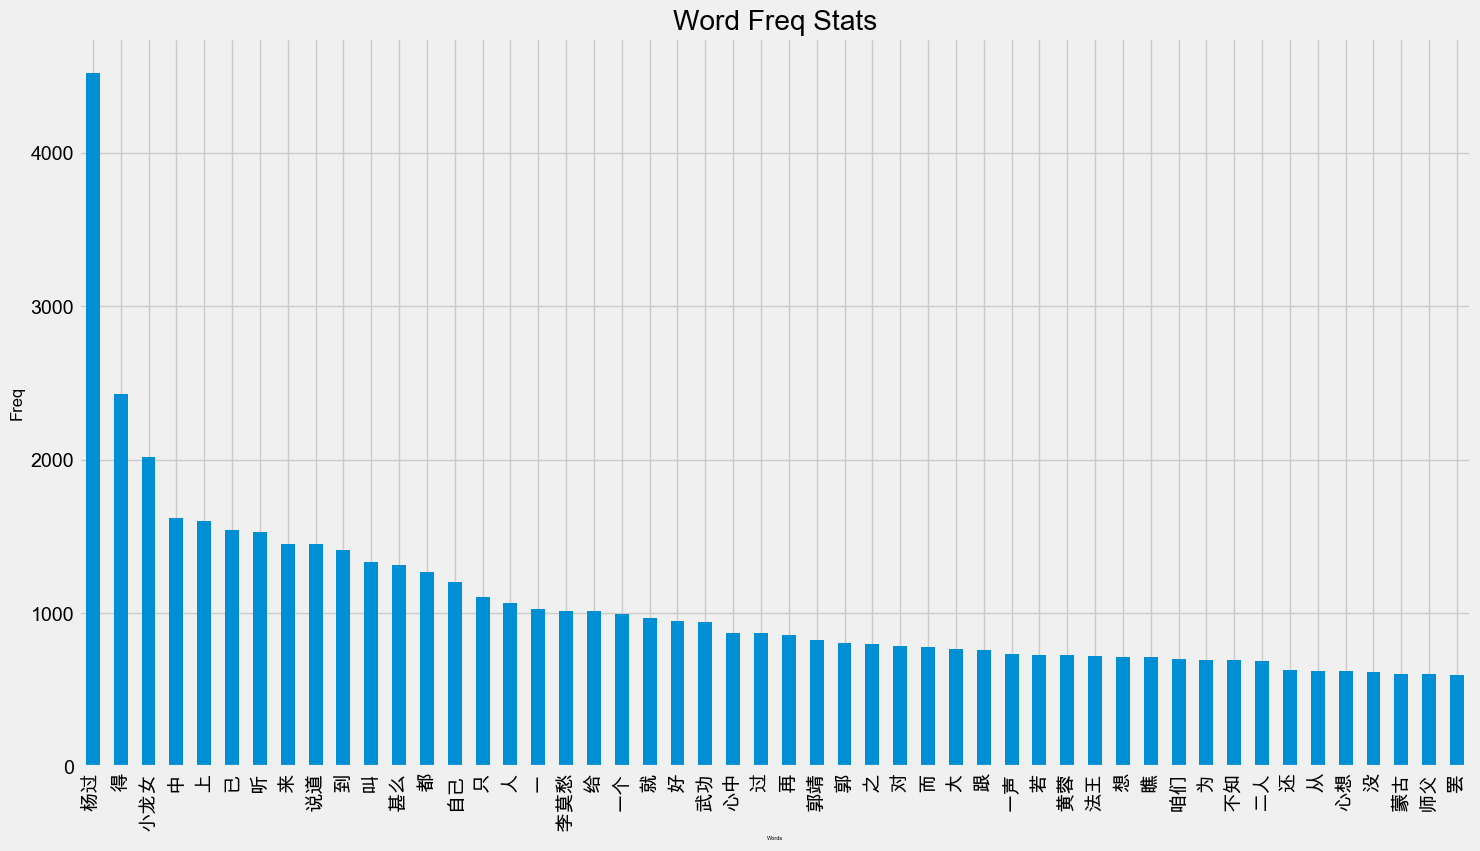

In [14]:
pd.set_option('display.max_rows', 120)
corpus = Corpus('/Users/zhuchengyao/PycharmProjects/AI_Course_2024/AI_Course_2024/bird_couple.txt')

word_counts = defaultdict(int)
for word_of_lines in corpus:
    for word in word_of_lines:
        word_counts[word] += 1


word_count_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
word_count_df.sort_values('count', ascending=False, inplace=True)
low_freq = word_count_df[word_count_df['count'] < 3]
low_freq_ratio = 1.0 * len(low_freq) / len(word_count_df)
print(f"low_freq_ratio:{100*low_freq_ratio:.2f}%")

plt.figure(figsize=(16, 9))
word_count_df[:50]['count'].plot(kind='bar')
plt.title('Word Freq Stats')
plt.xlabel('Words', fontsize=4)
plt.ylabel('Freq', fontsize=12)
plt.show()



In [15]:
valid_words = set(word_count_df.query("count >= 3").index.to_list())
print(f"total valid words: {len(valid_words)}")


# embedding called here, sg controls which algorithm we are going to use, 1 means we use skip-gram, 0 means use CBOW.
# window and vector_size is what we talked in the class
# min_count means we the token should be show more than min_count times, otherwise we are going to skip this token.
# negative means negative sample
# worker is general setting of system. How many thread you want.
model = gensim.models.Word2Vec(sg=1, window=10, vector_size=128, min_count=5, negative=10, workers=8)
model.build_vocab(corpus, progress_per=10000)
model.train(corpus, total_examples=model.corpus_count, epochs=30)

word_vec = model.wv



total valid words: 15646


--> dump the top k most related words
('小龙女', 0.7537715435028076)
('得', 0.583146333694458)
('叫', 0.5695760250091553)
('自己', 0.56145179271698)
('来', 0.55982506275177)
('甚么', 0.5557013154029846)
('已', 0.550672709941864)
('说道', 0.5490757822990417)
('上', 0.5428324341773987)
('只是', 0.5297966599464417)
51 51 51


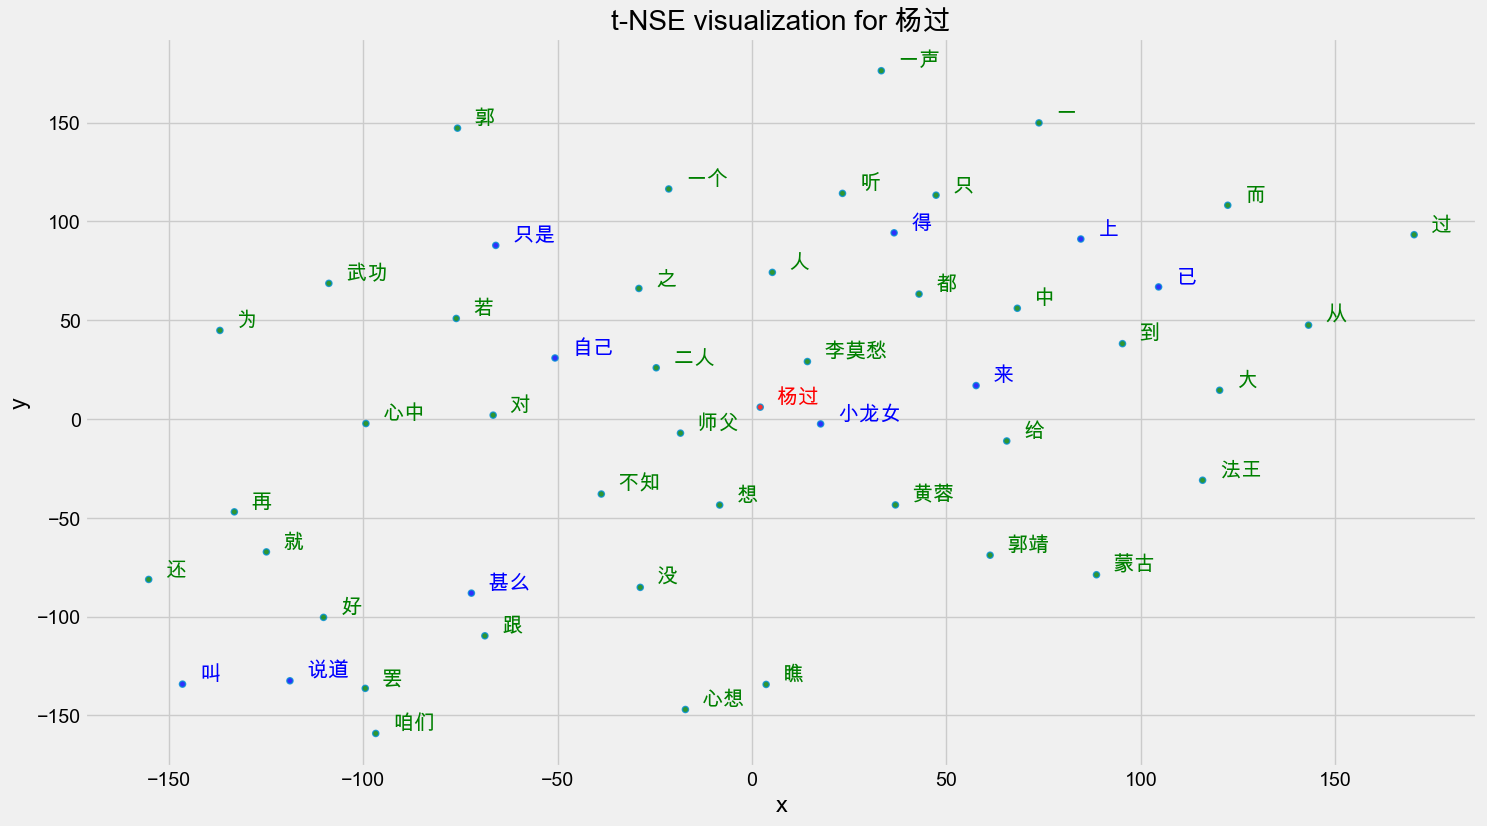

In [17]:
print("--> dump the top k most related words")
for sim_word in word_vec.most_similar(positive=['杨过'], topn=10):
    print(sim_word)

tsne_scatter_plot(model, '杨过')